In [8]:
import io, os, zipfile, textwrap, math
from typing import Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters, feature, color, exposure, morphology, util
from skimage.filters import gaussian, sobel, prewitt, scharr, laplace
from skimage.morphology import skeletonize
from skimage.restoration import denoise_bilateral
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, clear_output

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

In [10]:

print("Upload one or more images (png/jpg). For metrics, you can also upload a matching binary edge map named like 'yourimage_edges.png'.")
uploaded = files.upload()

# Separate normal images and potential ground-truth maps by suffix hint
images = {}
gt_edges = {}
for name, data in uploaded.items():
    name_l = name.lower()
    arr = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Skipping {name} (not an image)")
        continue
    if img.ndim == 2:
        pass
    elif img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    elif img.ndim == 3:
        pass
    if name_l.endswith(('_edges.png','_edges.jpg','_edge.png','_gt.png','_gt.jpg')):
        gt_edges[name] = img
    else:
        images[name] = img

print(f"Loaded {len(images)} image(s), {len(gt_edges)} GT map(s).")

Upload one or more images (png/jpg). For metrics, you can also upload a matching binary edge map named like 'yourimage_edges.png'.


Saving 20251104_195431.jpg to 20251104_195431.jpg
Saving 20190706_125335.jpg to 20190706_125335 (1).jpg
Loaded 2 image(s), 0 GT map(s).


In [11]:

def to_gray(img):
    if img.ndim == 2:
        g = img
    else:
        g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return g

def normalize01(a):
    a = a.astype('float32')
    a -= a.min()
    denom = a.max() - a.min() + 1e-8
    return a / denom

def sobel_edges(gray):
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(gx, gy)
    return normalize01(mag)

def prewitt_edges(gray):
    kx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]], dtype=np.float32)
    ky = np.array([[1,1,1],[0,0,0],[-1,-1,-1]], dtype=np.float32)
    gx = cv2.filter2D(gray, cv2.CV_32F, kx)
    gy = cv2.filter2D(gray, cv2.CV_32F, ky)
    mag = cv2.magnitude(gx, gy)
    return normalize01(mag)

def roberts_edges(gray):
    kx = np.array([[1, 0],
                   [0,-1]], dtype=np.float32)
    ky = np.array([[0, 1],
                   [-1,0]], dtype=np.float32)
    gx = cv2.filter2D(gray, cv2.CV_32F, kx)
    gy = cv2.filter2D(gray, cv2.CV_32F, ky)
    mag = cv2.magnitude(gx, gy)
    return normalize01(mag)

def scharr_edges(gray):
    gx = cv2.Scharr(gray, cv2.CV_32F, 1, 0)
    gy = cv2.Scharr(gray, cv2.CV_32F, 0, 1)
    mag = cv2.magnitude(gx, gy)
    return normalize01(mag)

def log_edges(gray, sigma=1.0):
    g = cv2.GaussianBlur(gray, (0,0), sigma)
    lap = cv2.Laplacian(g, cv2.CV_32F, ksize=3)
    return normalize01(np.abs(lap))

def dog_edges(gray, sigma1=1.0, sigma2=2.0):
    g1 = cv2.GaussianBlur(gray, (0,0), sigma1)
    g2 = cv2.GaussianBlur(gray, (0,0), sigma2)
    dog = g1 - g2
    return normalize01(np.abs(dog))

def canny_edges(gray, low, high, blur_sigma=1.0):
    g = cv2.GaussianBlur(gray, (0,0), blur_sigma)
    # OpenCV thresholds expect 0..255
    return cv2.Canny((g).astype(np.uint8), low, high)

def binarize(mag, thresh):
    return (mag >= thresh).astype(np.uint8)*255

def simple_metrics(pred_bin, gt_bin):
    # assumes uint8 0/255 inputs
    p = (pred_bin>0).astype(np.uint8)
    g = (gt_bin>0).astype(np.uint8)
    tp = np.sum((p==1)&(g==1))
    fp = np.sum((p==1)&(g==0))
    fn = np.sum((p==0)&(g==1))
    prec = tp/(tp+fp+1e-8)
    rec = tp/(tp+fn+1e-8)
    f1 = 2*prec*rec/(prec+rec+1e-8)
    iou = tp/(tp+fp+fn+1e-8)
    return dict(precision=float(prec), recall=float(rec), f1=float(f1), iou=float(iou))

def resize_max(img, max_side=900):
    h,w = img.shape[:2]
    scale = max_side / max(h,w)
    if scale >= 1:
        return img
    nh, nw = int(h*scale), int(w*scale)
    return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)


In [12]:

if not images:
    raise SystemExit('No images uploaded. Please run the upload cell above.')

# Pick the first image by default
img_names = list(images.keys())

img_dropdown = widgets.Dropdown(options=img_names, value=img_names[0], description='Image:')
sigma_slider = widgets.FloatSlider(value=1.0, min=0.5, max=5.0, step=0.1, description='Sigma')
sigma2_slider = widgets.FloatSlider(value=2.0, min=0.6, max=8.0, step=0.1, description='Sigma2 (DoG)')
thresh_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.01, description='Bin Thresh')
c_low = widgets.IntSlider(value=50, min=0, max=255, step=1, description='Canny low')
c_high = widgets.IntSlider(value=150, min=0, max=255, step=1, description='Canny high')
blur = widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='Blur σ (Canny)')

out = widgets.Output()

def refresh(*_):
    with out:
        clear_output(wait=True)
        img = images[img_dropdown.value]
        img = resize_max(img, 900)
        gray = to_gray(img)
        if gray.dtype != np.uint8:
            gray8 = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            gray8 = gray.copy()

        sob = sobel_edges(gray8)
        pre = prewitt_edges(gray8)
        rob = roberts_edges(gray8)
        sch = scharr_edges(gray8)
        lg = log_edges(gray8, sigma=sigma_slider.value)
        dg = dog_edges(gray8, sigma1=sigma_slider.value, sigma2=sigma2_slider.value)
        can = canny_edges(gray8, low=c_low.value, high=c_high.value, blur_sigma=blur.value)

        # Binarized gradients (Canny is already binary)
        sob_b = binarize(sob, thresh_slider.value)
        pre_b = binarize(pre, thresh_slider.value)
        rob_b = binarize(rob, thresh_slider.value)
        sch_b = binarize(sch, thresh_slider.value)
        lg_b = binarize(lg, thresh_slider.value)
        dg_b = binarize(dg, thresh_slider.value)

        # Plot grid (magnitude view): 3x3 accommodates 8 panels
        fig, axes = plt.subplots(3, 3, figsize=(16,12))
        axes = axes.ravel()
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); axes[0].set_title('Input'); axes[0].axis('off')
        axes[1].imshow(sob, cmap='gray'); axes[1].set_title('Sobel (mag)'); axes[1].axis('off')
        axes[2].imshow(pre, cmap='gray'); axes[2].set_title('Prewitt (mag)'); axes[2].axis('off')
        axes[3].imshow(rob, cmap='gray'); axes[3].set_title('Roberts (mag)'); axes[3].axis('off')
        axes[4].imshow(sch, cmap='gray'); axes[4].set_title('Scharr (mag)'); axes[4].axis('off')
        axes[5].imshow(lg, cmap='gray'); axes[5].set_title(f'LoG σ={sigma_slider.value:.1f}'); axes[5].axis('off')
        axes[6].imshow(dg, cmap='gray'); axes[6].set_title(f'DoG σ1={sigma_slider.value:.1f}, σ2={sigma2_slider.value:.1f}'); axes[6].axis('off')
        axes[7].imshow(can, cmap='gray'); axes[7].set_title(f'Canny [{c_low.value},{c_high.value}], blur σ={blur.value:.1f}'); axes[7].axis('off')
        axes[8].axis('off')
        plt.tight_layout()
        plt.show()

        # Binarized grid (including Canny)
        fig2, axes2 = plt.subplots(3, 3, figsize=(16,12))
        axes2 = axes2.ravel()
        axes2[0].imshow(gray8, cmap='gray'); axes2[0].set_title('Gray'); axes2[0].axis('off')
        axes2[1].imshow(sob_b, cmap='gray'); axes2[1].set_title(f'Sobel bin (t={thresh_slider.value:.2f})'); axes2[1].axis('off')
        axes2[2].imshow(pre_b, cmap='gray'); axes2[2].set_title('Prewitt bin'); axes2[2].axis('off')
        axes2[3].imshow(rob_b, cmap='gray'); axes2[3].set_title('Roberts bin'); axes2[3].axis('off')
        axes2[4].imshow(sch_b, cmap='gray'); axes2[4].set_title('Scharr bin'); axes2[4].axis('off')
        axes2[5].imshow(lg_b, cmap='gray'); axes2[5].set_title('LoG bin'); axes2[5].axis('off')
        axes2[6].imshow(dg_b, cmap='gray'); axes2[6].set_title('DoG bin'); axes2[6].axis('off')
        axes2[7].imshow(can, cmap='gray'); axes2[7].set_title('Canny (binary)'); axes2[7].axis('off')
        axes2[8].axis('off')
        plt.tight_layout()
        plt.show()

        # Metrics if GT available
        gt_name_candidates = [img_dropdown.value.replace('.png','_edges.png').replace('.jpg','_edges.png'),
                              img_dropdown.value.replace('.png','_gt.png').replace('.jpg','_gt.png')]
        found_gt = None
        for k in gt_edges.keys():
            if k in gt_name_candidates:
                found_gt = k; break
        if found_gt is not None:
            gt = to_gray(gt_edges[found_gt])
            # ensure binary 0/255
            _, gt_bin = cv2.threshold(gt, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            results = {}
            for name, pred in [('Sobel', sob_b), ('Prewitt', pre_b), ('Roberts', rob_b),
                               ('Scharr', sch_b), ('LoG', lg_b), ('DoG', dg_b), ('Canny', can)]:
                # Canny already binary 0/255
                pred_bin = pred if (isinstance(pred, np.ndarray) and pred.dtype==np.uint8) else (pred>0).astype(np.uint8)*255
                results[name] = simple_metrics(pred_bin, gt_bin)

            print('Metrics vs ground truth:', found_gt)
            for k,v in results.items():
                print(f"{k:8s} | Precision: {v['precision']:.3f}  Recall: {v['recall']:.3f}  F1: {v['f1']:.3f}  IoU: {v['iou']:.3f}")
        else:
            print('No matching ground truth found. To enable metrics, upload a binary map like: <imagename>_edges.png')

        # Save composite grids
        base = os.path.splitext(img_dropdown.value)[0]
        out1 = f"{base}_edges_grid.png"
        out2 = f"{base}_edges_binarized_grid.png"
        fig.savefig(out1, dpi=150, bbox_inches='tight')
        fig2.savefig(out2, dpi=150, bbox_inches='tight')
        print('Saved:', out1, 'and', out2)

for w in [img_dropdown, sigma_slider, sigma2_slider, thresh_slider, c_low, c_high, blur]:
    w.observe(refresh, names='value')

ui = widgets.VBox([img_dropdown,
                    widgets.HBox([sigma_slider, sigma2_slider]),
                    widgets.HBox([thresh_slider]),
                    widgets.HBox([c_low, c_high, blur])])
display(ui, out)
refresh()


Output()

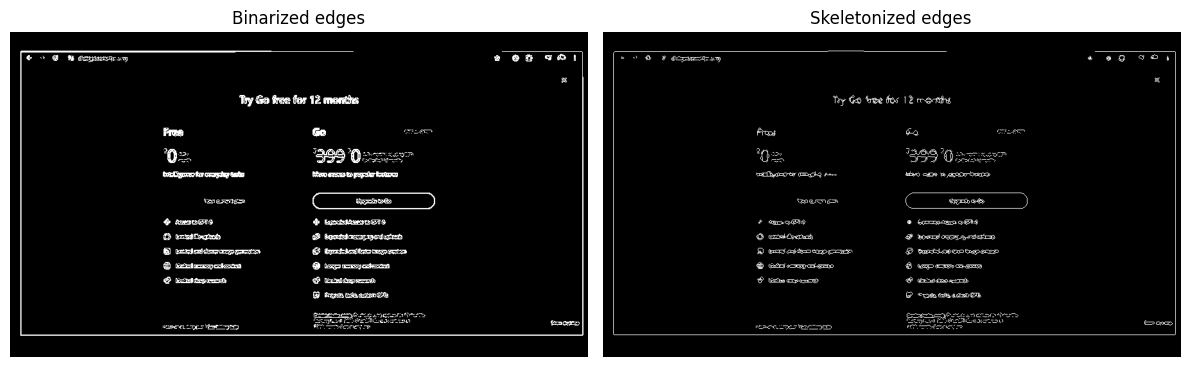

In [13]:

# Applies skeletonization to the chosen binarized edge map to produce 1px-wide edges
img = images[img_dropdown.value]
gray = to_gray(resize_max(img, 900))
mag = sobel_edges(gray)
bin_map = binarize(mag, thresh_slider.value) // 255  # 0/1
skeleton = skeletonize(bin_map.astype(bool))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(bin_map, cmap='gray'); plt.title('Binarized edges'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(skeleton, cmap='gray'); plt.title('Skeletonized edges'); plt.axis('off')
plt.tight_layout(); plt.show()

In [14]:

to_zip = [f for f in os.listdir('.') if f.endswith('_edges_grid.png') or f.endswith('_edges_binarized_grid.png')]
if not to_zip:
    print('No generated grids found. Run the interactive cell first.')
else:
    zname = 'edge_results.zip'
    with zipfile.ZipFile(zname, 'w', zipfile.ZIP_DEFLATED) as zf:
        for f in to_zip:
            zf.write(f)
    files.download(zname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>